In [221]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_validate
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report, r2_score
from six import StringIO
import pydotplus
from IPython.display import Image

In [222]:
data = pd.read_csv('data/Boston.csv', index_col=0).reset_index(drop=True).dropna()
data

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


In [223]:
X = data.drop(columns='medv')
y = data['medv']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)

In [224]:
# Create Regression Tree
regr_tree_medv = DecisionTreeRegressor(max_leaf_nodes=6, random_state=1)
regr_tree_medv.fit(X_train, y_train)

# Return R2
print('R2 training score: {:.4f}'.format(regr_tree_medv.score(X_train, y_train)))
print('')
# Return MSE training error
print('MSE training error: {:.4f}'.format(mean_squared_error(y_train, regr_tree_medv.predict(X_train))))

R2 training score: 0.8025

MSE training error: 16.0376


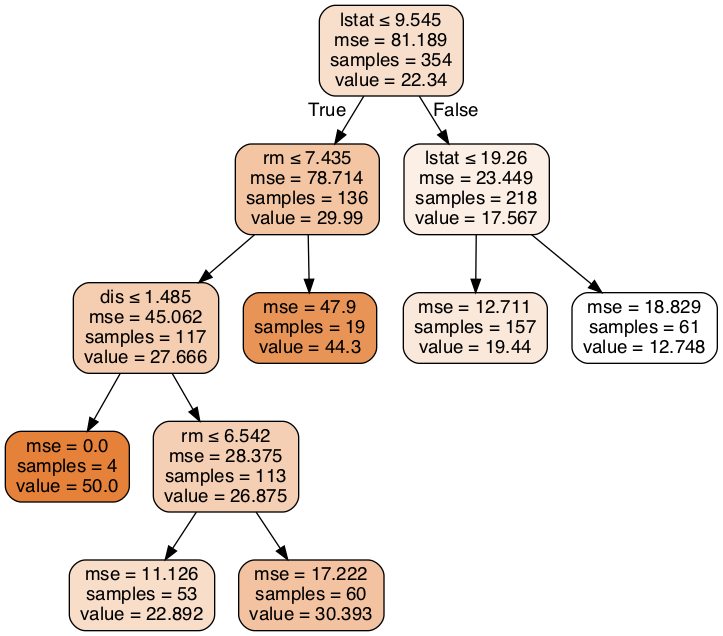

In [225]:
# Create Tree Chart
dot_data = StringIO()

export_graphviz(regr_tree_medv, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names=X.columns)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

Image(graph.create_png())

R2 test score: 0.8086

MSE test error: 17.5412



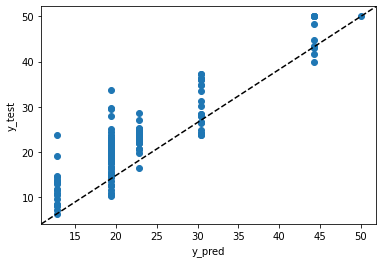

In [226]:
# Calculate R2 test score
y_pred = regr_tree_medv.predict(X_test)
print('R2 test score: {:.4f}'.format(r2_score(y_test, y_pred)))
print('')
print('MSE test error: {:.4f}'.format(mean_squared_error(y_test, y_pred)))
print('')

# Plot Chart y_pred, y_test
# plt.figure(8,6)
plt.scatter(y_pred, y_test)
plt.plot([0, 1], [0, 1], '--k', transform = plt.gca().transAxes)
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

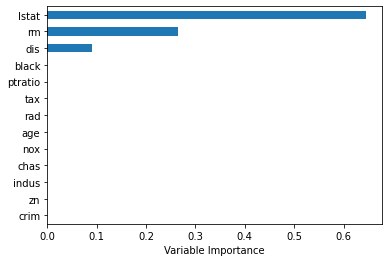

In [227]:
# Create feature importances
feature_importances = pd.DataFrame(regr_tree_medv.feature_importances_, index=X.columns, columns=['Importance']).sort_values(by='Importance').plot(kind='barh')
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

In [228]:
# Calculate alphas, impurities effective range
regr_tree = DecisionTreeRegressor(random_state=1)
path = regr_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas_train, impurities_tran = path.ccp_alphas, path.impurities

In [229]:
# Draw Chart alphas vs impurities
def display_regr_tree_pruning_result(ccp_alphas, X_train, X_test, y_train, y_test):

    # Create data
    impurity = []
    leaves_counts = []
    train_r2, test_r2 = [], []
    train_mse, test_mse = [], []
    for ccp_alpha in ccp_alphas:

        # Create a list model due to changes of alpha
        regr_tree = DecisionTreeRegressor(ccp_alpha=ccp_alpha, random_state=1)
        regr_tree.fit(X_train, y_train)

        # Append result on node counts, r2, mse
        impurity.append(regr_tree.tree_.impurity.mean())
        leaves_counts.append(regr_tree.tree_.n_leaves)
        train_r2.append(regr_tree.score(X_train, y_train))
        test_r2.append(regr_tree.score(X_test, y_test))
        train_mse.append(mean_squared_error(y_train, regr_tree.predict(X_train)))
        test_mse.append(mean_squared_error(y_test, regr_tree.predict(X_test)))

    # Wrap to numpy array to for easy to manipulate
    impurity = np.array(impurity)
    leaves_counts = np.array(leaves_counts)
    train_r2 = np.array(train_r2)
    test_r2 = np.array(test_r2)
    train_mse = np.array(train_mse)
    test_mse = np.array(test_mse)

    k = test_mse.argmin()
    k_f = k + 5
    k_b = k - 20

    # Start plot data
    plt.figure(figsize=(16,12))

    plot_1 = plt.subplot(2,2,1)
    plt.plot(ccp_alphas[:-1], impurity[:-1], marker='o', drawstyle='steps-post')
    plt.xlabel('Alphas')
    plt.ylabel('Impurities of leaves')
    plt.title('Impurities vs Alphas for training set')

    plot_2 = plt.subplot(2,2,2)
    plt.plot(ccp_alphas[k_b:k_f], leaves_counts[k_b:k_f], drawstyle='steps-post')
    plt.plot(ccp_alphas[k], leaves_counts[k], 'ro', label='At min test MSE, alpha: {:.4f}, number Leaves: {}'.format(ccp_alphas[k], leaves_counts[k]))
    plt.xlabel('Alphas')
    plt.ylabel('Number of Leaves')
    plt.legend()
    plt.title('Number of Leaves vs Alphas for training set')

    plot_3 = plt.subplot(2,2,3)
    plt.plot(ccp_alphas[k_b:k_f], train_r2[k_b:k_f], drawstyle='steps-post', label='train R2')
    plt.plot(ccp_alphas[k_b:k_f], test_r2[k_b:k_f], drawstyle='steps-post', label='test R2')
    plt.plot(ccp_alphas[k], test_r2[k], 'ro', label='Max test R2: {:.4f} at alpha: {:.4f}'.format(test_r2[k], ccp_alphas[k]))
    plt.xlabel('Alphas')
    plt.ylabel('R2')
    plt.legend()
    plt.title('R2 vs Alphas on train-test set')

    plot_4 = plt.subplot(2,2,4)
    plt.plot(ccp_alphas[k_b:k_f], train_mse[k_b:k_f], drawstyle='steps-post', label='train MSE')
    plt.plot(ccp_alphas[k_b:k_f], test_mse[k_b:k_f], drawstyle='steps-post', label='test MSE')
    plt.plot(ccp_alphas[k], test_mse[k], 'ro', label='Min test MSE: {:.4f} at alpha: {:.4f}'.format(test_mse[k], ccp_alphas[k]))
    plt.xlabel('Alphas')
    plt.ylabel('MSE')
    plt.legend()
    plt.title('MSE vs Alphas on train-test set')

    plt.show()

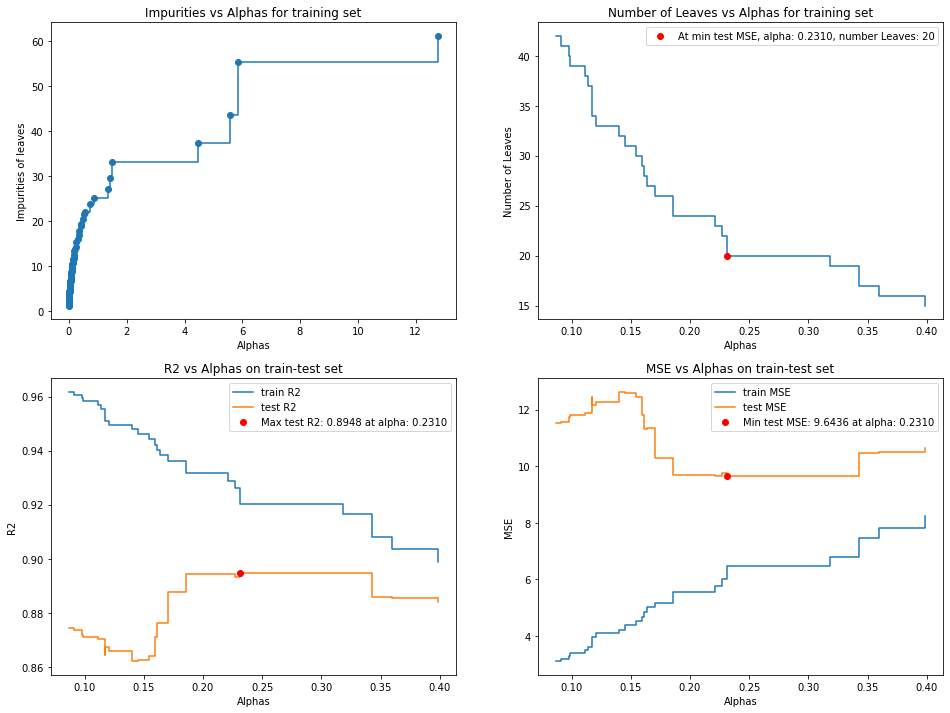

In [230]:
display_regr_tree_pruning_result(ccp_alphas_train, X_train, X_test, y_train, y_test)

In [231]:
# Calculate optimal alpha for Pruning Tree by using Cross-validation
def display_regr_tree_pruning_cv_result(ccp_alphas, X, y):

    cv = KFold(n_splits=10, shuffle=True, random_state=1)

    # Create data
    train_r2 = []
    test_r2 = []
    train_mse = []
    test_mse = []
    for ccp_alpha in ccp_alphas:

        # Create a list model due to changes of alpha
        regr_tree = DecisionTreeRegressor(ccp_alpha=ccp_alpha, random_state=1)
        score = cross_validate(regr_tree, X, y, cv=cv, scoring=('r2', 'neg_mean_squared_error'), return_train_score=True)

        # Append result mean r2, mse
        train_r2.append(np.mean(score['train_r2']))
        test_r2.append(np.mean(score['test_r2']))
        train_mse.append(np.mean(np.abs(score['train_neg_mean_squared_error'])))
        test_mse.append(np.mean(np.abs(score['test_neg_mean_squared_error'])))

    # Wrap to numpy array to for easy to manipulate
    train_r2 = np.array(train_r2)
    test_r2 = np.array(test_r2)
    train_mse = np.array(train_mse)
    test_mse = np.array(test_mse)

    k = test_mse.argmin()
    k_f_bound = len(test_mse)-1-k
    k_f = k + k_f_bound
    k_b = k - k

    optimal_regr_tree = DecisionTreeRegressor(random_state=1, ccp_alpha=ccp_alphas[k]).fit(X, y)
    leaves = optimal_regr_tree.tree_.n_leaves

    # Start plot data
    plt.figure(figsize=(16,6))

    plot_1 = plt.subplot(1,2,1)
    plt.plot(ccp_alphas[k_b:k_f], train_r2[k_b:k_f], drawstyle='steps-post', label='train R2')
    plt.plot(ccp_alphas[k_b:k_f], test_r2[k_b:k_f], label='test R2')
    plt.plot(ccp_alphas[k], test_r2[k], 'ro', label='Max test R2: {:.4f} at alpha: {:.4f}, {} leaves'.format(test_r2[k], ccp_alphas[k], leaves))
    plt.xlabel('Alphas')
    plt.ylabel('R2')
    plt.legend()
    plt.title('R2 test set')

    plot_2 = plt.subplot(1,2,2)
    plt.plot(ccp_alphas[k_b:k_f], train_mse[k_b:k_f], drawstyle='steps-post', label='train MSE')
    plt.plot(ccp_alphas[k_b:k_f], test_mse[k_b:k_f], label='test MSE')
    plt.plot(ccp_alphas[k], test_mse[k], 'ro', label='Min test MSE: {:.4f} at alpha: {:.4f}, {} leaves'.format(test_mse[k], ccp_alphas[k], leaves))
    plt.xlabel('Alphas')
    plt.ylabel('MSE')
    plt.legend()
    plt.title('MSE test-error')

    plt.show()

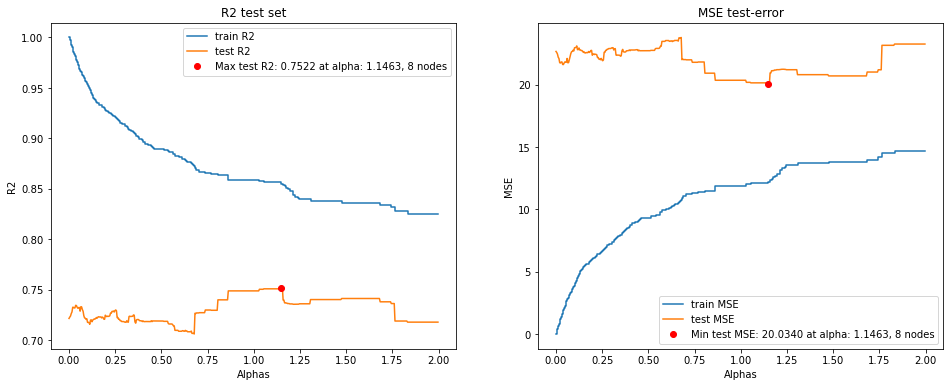

In [232]:
ccp_alphas_cv = np.linspace(0,2,500)
display_regr_tree_pruning_cv_result(ccp_alphas_cv, X, y)

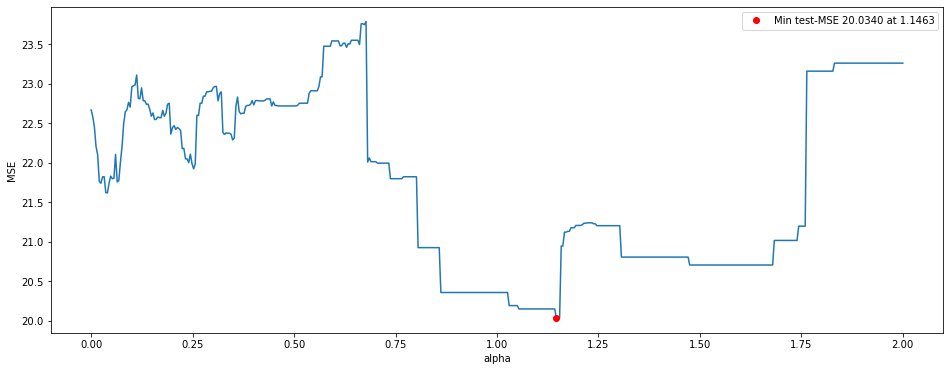

In [254]:
# Pruning the decision tree, use cross-validation to find alpha
cv = KFold(n_splits=10, shuffle=True, random_state=1)
mse = []
alphas = ccp_alphas_cv
for a in alphas:
    regr_tree = DecisionTreeRegressor(ccp_alpha=a, random_state=1)
    score = cross_val_score(regr_tree, X, y, cv=cv, scoring='neg_mean_squared_error')
    mse.append(np.mean(np.abs(score)))

mse = np.array(mse)
k = mse.argmin()
alpha_min = alphas[k]

plt.figure(figsize=(16,6))
plt.plot(alphas, mse)
plt.plot(alpha_min, mse.min(), 'ro', label='Min test-MSE {:.4f} at {:.4f}'.format(mse.min(), alpha_min))
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [260]:
# Use Crossvalidation to find optimal max leaves
def display_regr_tree_pruning_cv_result_leaves(leaves_range, X, y):

    cv = KFold(n_splits=10, shuffle=True, random_state=1)

    # Create data
    train_r2 = []
    test_r2 = []
    train_mse = []
    test_mse = []
    for i in leaves_range:

        # Create a list model due to changes of alpha
        regr_tree = DecisionTreeRegressor(max_leaf_nodes=i, random_state=1)
        score = cross_validate(regr_tree, X, y, cv=cv, scoring=('r2', 'neg_mean_squared_error'), return_train_score=True)

        # Append result mean r2, mse
        train_r2.append(np.mean(score['train_r2']))
        test_r2.append(np.mean(score['test_r2']))
        train_mse.append(np.mean(np.abs(score['train_neg_mean_squared_error'])))
        test_mse.append(np.mean(np.abs(score['test_neg_mean_squared_error'])))

    # Wrap to numpy array to for easy to manipulate
    train_r2 = np.array(train_r2)
    test_r2 = np.array(test_r2)
    train_mse = np.array(train_mse)
    test_mse = np.array(test_mse)

    k = test_mse.argmin()

    # Start plot data
    plt.figure(figsize=(16,6))

    plot_1 = plt.subplot(1,2,1)
    plt.plot(leaves_range, train_r2, label='train R2')
    plt.plot(leaves_range, test_r2, label='test R2')
    plt.plot(leaves_range[k], test_r2[k], 'ro', label='Max test R2: {:.4f} at {} leaves'.format(test_r2[k], leaves_range[k]))
    plt.xlabel('Max Leaf nodes')
    plt.ylabel('R2')
    plt.xticks(leaves_range)
    plt.legend()
    plt.title('R2 test set')

    plot_2 = plt.subplot(1,2,2)
    plt.plot(leaves_range, train_mse, label='train MSE')
    plt.plot(leaves_range, test_mse, label='test MSE')
    plt.plot(leaves_range[k], test_mse[k], 'ro', label='Min test MSE: {:.4f} at max {} leaves'.format(test_mse[k], leaves_range[k]))
    plt.xlabel('Max Leaf nodes')
    plt.ylabel('MSE')
    plt.xticks(leaves_range)
    plt.legend()
    plt.title('MSE test-error')

    plt.show()

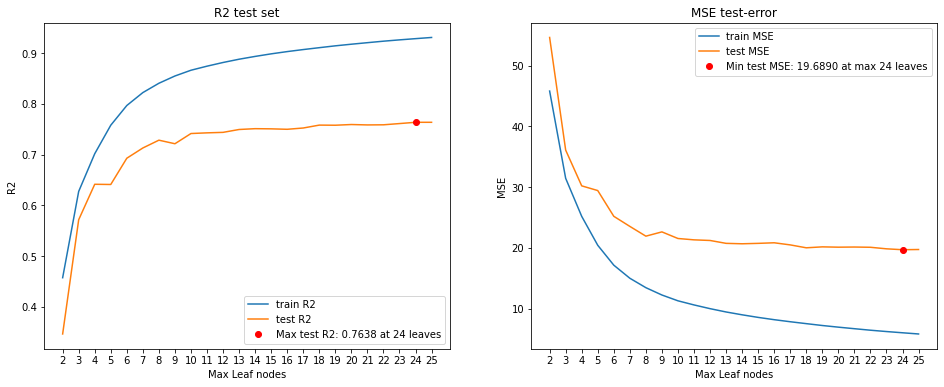

In [261]:
leaves_range = np.arange(2,26)
display_regr_tree_pruning_cv_result_leaves(leaves_range, X, y)

In [262]:
# Fit model again which optimal alpha from cross-validation
# Create Regression Tree
regr_tree_medv = DecisionTreeRegressor(random_state=1, ccp_alpha=alpha_min)
regr_tree_medv.fit(X, y)

# Return R2
print('R2 training score: {:.4f}'.format(regr_tree_medv.score(X, y)))
print('')
# Return MSE training error
print('MSE training error: {:.4f}'.format(mean_squared_error(y, regr_tree_medv.predict(X))))

R2 training score: 0.8385

MSE training error: 13.6323


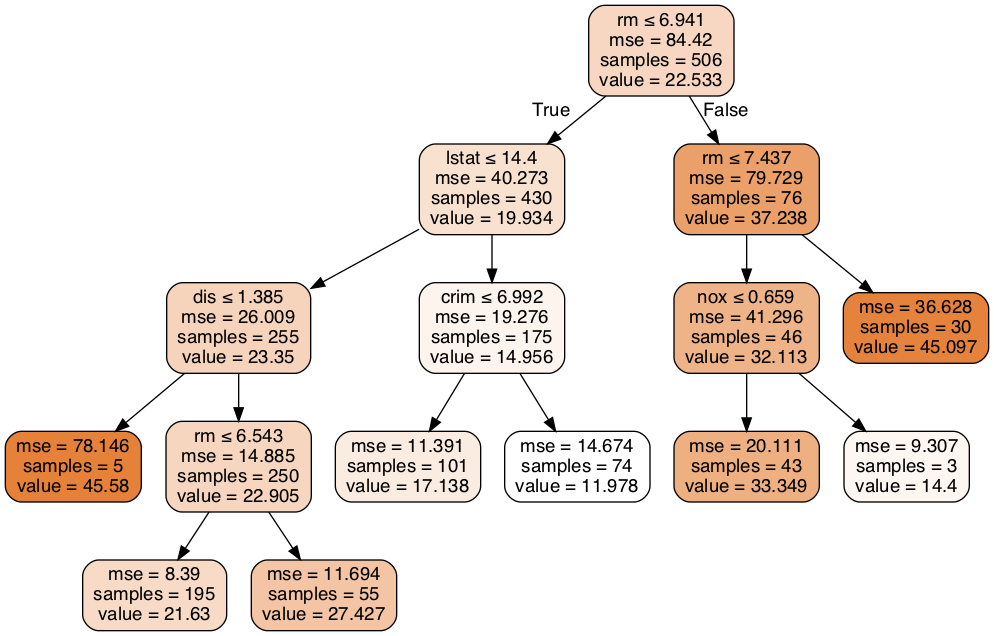

In [263]:
# Create Tree Chart
dot_data = StringIO()

export_graphviz(regr_tree_medv, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names=X.columns)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

Image(graph.create_png())

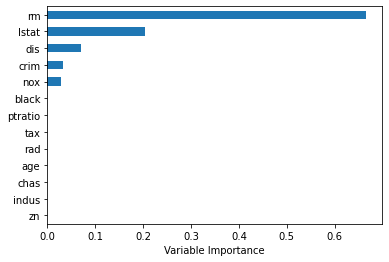

In [264]:
# Create feature importances
feature_importances = pd.DataFrame(regr_tree_medv.feature_importances_, index=X.columns, columns=['Importance']).sort_values(by='Importance').plot(kind='barh')
plt.xlabel('Variable Importance')
plt.gca().legend_ = None